# Faculty Analysis

Mostly this notebook is pre-processing and tidying the data for the R analysis.

## Loading the data from mturk

In [27]:
from ast import literal_eval
from itertools import chain
from datetime import datetime, date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

pd.set_option('display.max_columns', 50)
%matplotlib inline

In [2]:
experiment = "faculty"

In [3]:
df = pd.read_csv(f"../raw-data/{experiment}.csv")

df.head()

,hit_id,assignment_id,worker_id,variable,value
0,FACULTY_20210816_prod,d489de33-e5b1-4829-b6c2-a0817d6a3b51,35010157605115141260511511080192024,experiment,PAPER_REVIEW_PILOT2
1,FACULTY_20210816_prod,d489de33-e5b1-4829-b6c2-a0817d6a3b51,35010157605115141260511511080192024,stage,INITIAL_PAGE_LOAD
2,FACULTY_20210816_prod,d489de33-e5b1-4829-b6c2-a0817d6a3b51,35010157605115141260511511080192024,variant,FACULTY
3,FACULTY_20210816_prod,d489de33-e5b1-4829-b6c2-a0817d6a3b51,35010157605115141260511511080192024,condition,SE_NO_FEEDBACK
4,FACULTY_20210816_prod,d489de33-e5b1-4829-b6c2-a0817d6a3b51,35010157605115141260511511080192024,currentTime,1629123522396


In [4]:
print(f"Overall, there are {df.assignment_id.nunique()} unique assignmentIds")

Overall, there are 566 unique assignmentIds


In [5]:
df.assignment_id.value_counts().value_counts()

199    288
24      77
12      46
37      42
51      33
67      29
86      20
162      7
105      6
143      6
180      6
124      4
98       1
185      1
Name: assignment_id, dtype: int64

# Analysis of Part I

Since we have more data for Part I of the experiment, let's look at that first.

In [6]:
stage_markers = df[df.variable == 'experiment'].index

In [7]:
df_stages = []

for stage_start, stage_end in zip(stage_markers, np.concatenate([stage_markers[1:], [len(df)]])):
    df_stage = df.iloc[stage_start:stage_end]
    df_stage_pivoted = df_stage.pivot(index='assignment_id', columns='variable', values='value')
    
    df_stages.append(df_stage_pivoted)

In [8]:
def literal_eval_if_present(val):
    if pd.isnull(val):
        return val
    
    return literal_eval(val)


def get_if_present(col, val):
    if pd.isnull(val):
        return val
    
    return val[col]


def in_get_if_present(col, inner, val):
    gotten = get_if_present(col, val)
    
    try:
        return inner in gotten
    except TypeError:
        return gotten
    

def int_if_present(val):
    if pd.isnull(val):
        return val
    
    return int(val)

df_by_stage = pd.concat(df_stages)
df_by_stage['paperA_editorialResponse'] = df_by_stage['paperA_editorialResponse'].apply(literal_eval_if_present)
df_by_stage['scenario'] = df_by_stage['scenario'].apply(literal_eval_if_present)
df_by_stage['background'] = df_by_stage['background'].apply(literal_eval_if_present)
df_by_stage['guess'] = df_by_stage['guess'].apply(int_if_present)
df_by_stage['currentTime'] = df_by_stage['currentTime'].apply(int_if_present)
df_by_stage['startTime'] = df_by_stage['startTime'].apply(int_if_present)

{'departmentField': 'statistics',
 'isTenureTrackFaculty': 'no',
 'comfortWithStats': '5',
 'comfortWithData': '5',
 'taughtStats': 'Yes',
 'papersReviewed': '50-100'}

editorialQs = ['q_appeal', 'q_sample_size', 'q_overall']
scenarioVars = ['mu1', 'mu2', 'variance1', 'variance2', 'n1', 'n2', 'probOfSuperiority']
statsVars = ['departmentField', 'isTenureTrackFaculty', 'comfortWithStats', 'comfortWithData', 'taughtStats', 'papersReviewed']

for q in editorialQs:
    df_by_stage[q] = df_by_stage.paperA_editorialResponse.apply(lambda x: get_if_present(q, x))

for v in scenarioVars:
    df_by_stage[v] = df_by_stage.scenario.apply(lambda x: get_if_present(v, x))

for v in statsVars:
    df_by_stage[v] = df_by_stage.background.apply(lambda x: get_if_present(v, x))

df_by_stage.head()

variable,assignmentId,condition,currentTime,experiment,hitId,id,stage,startTime,study_id,turkSubmitTo,variant,workerId,paperA_editorialResponse,paperA_superiorityEstimate,paperA_whatYouSaw,paperA_whatYouSaw2,guess,scenario,trial,background,feedback,q_appeal,q_sample_size,q_overall,mu1,mu2,variance1,variance2,n1,n2,probOfSuperiority,departmentField,isTenureTrackFaculty,comfortWithStats,comfortWithData,taughtStats,papersReviewed
assignment_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
d489de33-e5b1-4829-b6c2-a0817d6a3b51,d489de33-e5b1-4829-b6c2-a0817d6a3b51,SE_NO_FEEDBACK,1629123522396,PAPER_REVIEW_PILOT2,FACULTY_20210816_prod,ff61b793-c49d-4e34-8265-ee35a4bdca73,INITIAL_PAGE_LOAD,1629123522355,paper-review-pilot-2,None,FACULTY,35010157605115141260511511080192024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e6bb3497-3963-4c0d-848d-9be80c22cfe8,e6bb3497-3963-4c0d-848d-9be80c22cfe8,SE_POINTS_NO_FEEDBACK,1629123537366,PAPER_REVIEW_PILOT2,FACULTY_20210816_prod,96a3ac87-d7bb-446d-836f-1270f10874f3,INITIAL_PAGE_LOAD,1629123537317,paper-review-pilot-2,None,FACULTY,35010157605115141260511511080192024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2bcda2d4-9071-4be3-a835-40d2a08d0fc1,2bcda2d4-9071-4be3-a835-40d2a08d0fc1,SE_POINTS_NO_FEEDBACK,1629127672152,PAPER_REVIEW_PILOT2,FACULTY_20210816_prod,a4402841-1597-4357-a06e-721a3d040e2a,INITIAL_PAGE_LOAD,1629127672031,paper-review-pilot-2,None,FACULTY,4501006464537369204515131537363864153624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2bcda2d4-9071-4be3-a835-40d2a08d0fc1,2bcda2d4-9071-4be3-a835-40d2a08d0fc1,SE_POINTS_NO_FEEDBACK,1629127693898,PAPER_REVIEW_PILOT2,FACULTY_20210816_prod,efbeb6e0-eca6-412d-8e59-636951b7e692,PAPER_A_PREFACE,1629127672031,paper-review-pilot-2,None,FACULTY,4501006464537369204515131537363864153624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2bcda2d4-9071-4be3-a835-40d2a08d0fc1,2bcda2d4-9071-4be3-a835-40d2a08d0fc1,SE_POINTS_NO_FEEDBACK,1629127796257,PAPER_REVIEW_PILOT2,FACULTY_20210816_prod,27d7c08c-8034-48b8-a211-425ee5bc8192,PAPER_A_REVIEW,1629127672031,paper-review-pilot-2,None,FACULTY,4501006464537369204515131537363864153624,"{'q_appeal': '4', 'q_sample_size': '5', 'q_ove...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Filter faculty who replied after Thursday August 26th

print("Before filtering on date: ", len(df_by_stage))
df_by_stage = df_by_stage[(df_by_stage['startTime'] / 1000).apply(lambda x: datetime.fromtimestamp(x).date()) <= date(2021, 8, 26)]
print("After removing responses after August 26th, 2021: ", len(df_by_stage))

Before filtering on date:  4460
After removing responses after August 26th, 2021:  4460


In [10]:
df_trials = df_by_stage[~df_by_stage.trial.isnull()]

# only keep people who finished all 5 trials
df_trials = df_trials[
    df_trials.groupby('assignmentId').trial.transform('count') == 5
]

df_trials['psup'] = (df_trials.probOfSuperiority*100).astype(int)
df_trials['signed_error'] = df_trials.guess - df_trials.psup
df_trials['unsigned_error'] = np.abs(df_trials.guess - df_trials.psup)

# Feedback

In [11]:
df_by_stage[df_by_stage.stage == 'FEEDBACK'].feedback.dropna().values

array(['I found it more challenging than expected since my discipline deals w/ much larger N studies in which scatterplots or graphs showing individual data points are rarely informative. Good luck w/ your project. ',
       'Interesting exercise!',
       "It's profoundly stoopid to estimate these probabilities; they are not what is at stake in hypothesis testing.  If one wants to know those probabilities, one can write code to calculate them from normal distribution tables, which is why is entered the lowest estimate possible for all of them.  Stoopid questions indeed.",
       'Cool study and I like the "reward" for participation!',
       "Ok, I've reviewed lots of papers, but never an experiment (or even group differences with small Ns).  So these were all wild guesses.",
       "It took me a few goes to recognize your jargon. What you were calling standard error, I *think* was what I know as the standard error of the mean which is roughly the sd/sqrt(N). After I caught on that yo

In [12]:
df_by_stage[df_by_stage.stage == 'FEEDBACK'].dropna(subset=['feedback'])[['assignmentId', 'workerId', 'condition', 'feedback']].to_csv(f"../tidy-data/{experiment}-tidy-feedback.tsv", sep="\t")

### Timing data

We recorded timestamps of the start and end in milliseconds since the Epoch. Mostly we are curious if they are completing the task too quickly (<3 minutes?)

In [13]:
df_by_stage['elapsed'] = df_by_stage['currentTime'] - df_by_stage['startTime']

In [14]:
end_of_part1 = df_by_stage[df_by_stage.stage == 'PSUP_GAME_PREFACE'].currentTime - df_by_stage[df_by_stage.stage == 'PSUP_GAME_PREFACE'].startTime
feedback_stage = df_by_stage[df_by_stage.stage == 'FEEDBACK'].currentTime - df_by_stage[df_by_stage.stage == 'FEEDBACK'].startTime

(0.0, 100.0)

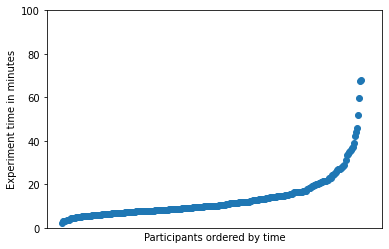

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(
    range(len(feedback_stage)),
    (feedback_stage / 1000 / 60).sort_values(),
)

ax.set_xlabel("Participants ordered by time")
ax.set_xticks([])
ax.set_ylabel("Experiment time in minutes")
ax.set_ylim([0, 100])

# Cleanup before outputting

We want the data to be tidy. Thus we will end up with four dataframes:

* first is editorial
* second is psup game 
* third is time stamps, with all stages (and maybe ts_trial_1, ts_trial_2, etc. for psup game?)
* fourth is background survey

In [16]:
df_last_stage_per_assignment = df_by_stage.sort_values(by=['assignmentId', 'elapsed']).groupby('assignment_id').last()

In [17]:
# New rule is that editorial data must have Part I of experiment completed
# (ie, finished the PAPER_A_UNDERSTANDING stage)

df_tidy_editorial = df_by_stage[df_by_stage.stage == 'PAPER_A_UNDERSTANDING'].drop(['currentTime', 'startTime', 'turkSubmitTo', 'guess', 'scenario', 'trial', 'background', 'feedback', 'mu1', 'mu2', 'variance1', 'variance2', 'n1', 'n2', 'probOfSuperiority'] + statsVars, axis=1)
df_tidy_editorial.to_csv(f"../tidy-data/{experiment}-tidy-editorial.csv", index=False)

In [18]:
# How much data will we lose if we require people finish Part I completely?

print("Number of people who made it to various stages:")
print(df_by_stage.drop_duplicates(['assignmentId', 'stage']).stage.value_counts())

Number of people who made it to various stages:
INITIAL_PAGE_LOAD        566
PAPER_A_PREFACE          519
PAPER_A_REVIEW           443
PAPER_A_PSUP             399
PAPER_A_UNDERSTANDING    368
PSUP_GAME                339
BACKGROUND_SURVEY        295
FEEDBACK                 289
Name: stage, dtype: int64


In [30]:
with open(f"./results/{experiment}_finishers_by_stage.json", "w") as out:
    json.dump(
        df_by_stage.drop_duplicates(['assignmentId', 'stage']).stage.value_counts().reset_index().rename(columns={'index': 'stage', 'stage': 'finishers'}).set_index("stage").to_dict()['finishers'],
        out
    )

In [19]:
common_vars = ['assignmentId', 'condition', 'experiment', 'hitId', 'id', 'study_id', 'workerId', ]

In [20]:
# Writing out psup game trials

df_trials[common_vars + ['guess', 'trial', 'mu1', 'mu2', 'variance1', 'variance2', 'n1', 'n2', 'psup', 'signed_error', 'unsigned_error']].to_csv(f"../tidy-data/{experiment}-tidy-psup-game.csv", index=False)

In [21]:
# Writing out background data

df_background_data = df_last_stage_per_assignment[common_vars + statsVars]
df_background_data.to_csv(f"../tidy-data/{experiment}-tidy-background.csv", index=False)

In [22]:
# Writing out timing data

df_by_stage['stage_trial'] = df_by_stage.stage + '-' + df_by_stage.trial.fillna('1')
df_by_stage[common_vars + ['stage', 'trial', 'stage_trial', 'elapsed']].to_csv(f"../tidy-data/{experiment}-tidy-elapsed.csv", index=False)